### Name - Aditya Bhawsar
### PRN - 250240128002

## 1. Import Statements
Import all the libraries.

In [ ]:
###-----------------
### Import Libraries
###-----------------

import os
import time
import numpy as np
import pandas as pd

from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import v2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt

# from utils.torch_helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [ ]:
###------------------
### Global Parameters
###------------------
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


# TEST_SIZE  = 0.2 # Size of test data
ALPHA = 0.001
EPOCHS = 50
WEIGHT_DECAY = 0.001
BATCH_SIZE = 16

PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10
# LR_MIN = 1e-6

IMG_HEIGHT = 32
IMG_WIDTH = 32
EPSILON = 1e-8 #minimum difference
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.jet

plt.rcParams.update(params)

In [ ]:
train_df = pd.read_csv('/content/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashion-mnist_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def fn_imshow(image, ax=None, title=None, normalize=True):
  if ax is None:
    fig, ax = plt.subplots() #create axis to plot on
  image = image.numpy().transpose((1,2,0))

  if normalize: #normalize the data
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image*std + mean
    image = np.clip(image, 0, 1)

  ax.imshow(image) #display image
  ax.set_title(title) #show title on image

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')



In [ ]:
transform = v2.Compose([
    v2.ToImage(), #image are being read as PIL
    v2.ConvertImageDtype(torch.float),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])])

In [ ]:
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Separate features and target
        self.image = self.dataframe.drop(columns='label')
        self.label = self.dataframe['label']

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.dataframe.iloc[idx]
        label = row.iloc[0]
        image = row.iloc[1:].values.astype(np.uint8).reshape(28, 28)
        image = np.expand_dims(image, axis=0)

        # Convert to 3 channels by repeating the single channel
        image = np.repeat(image, 3, axis=0)

        # Convert the NumPy array to a PyTorch tensor and cast to float
        image = torch.from_numpy(image).float() # <-- Add this line

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Create instances of the custom dataset
train_dataset = FashionMNISTDataset(train_df)
test_dataset = FashionMNISTDataset(test_df)

In [ ]:
trainloader = DataLoader(train_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         )


testloader = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        )

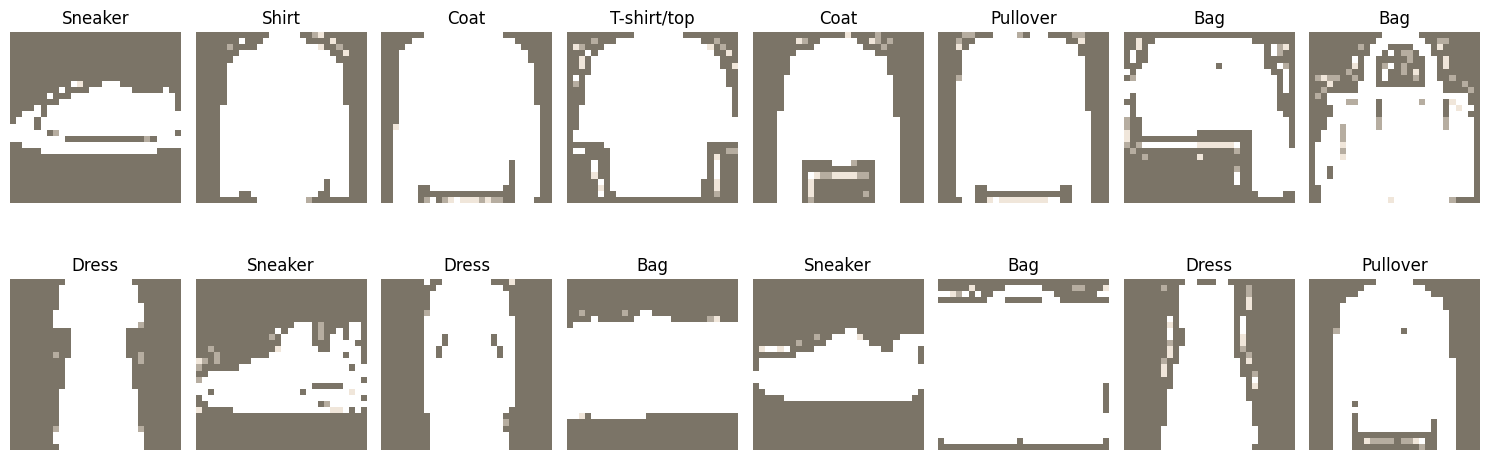

In [ ]:
images, labels = next(iter(trainloader))
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1., top=1., wspace=0.05, hspace=0.05)

for i in range(BATCH_SIZE):
  ax = fig.add_subplot(BATCH_SIZE//8, 8, (i+1) , xticks=[], yticks=[])
  fn_imshow(images[i], ax= ax, normalize=True,
            title=class_names[labels[i].item()])
plt.tight_layout()

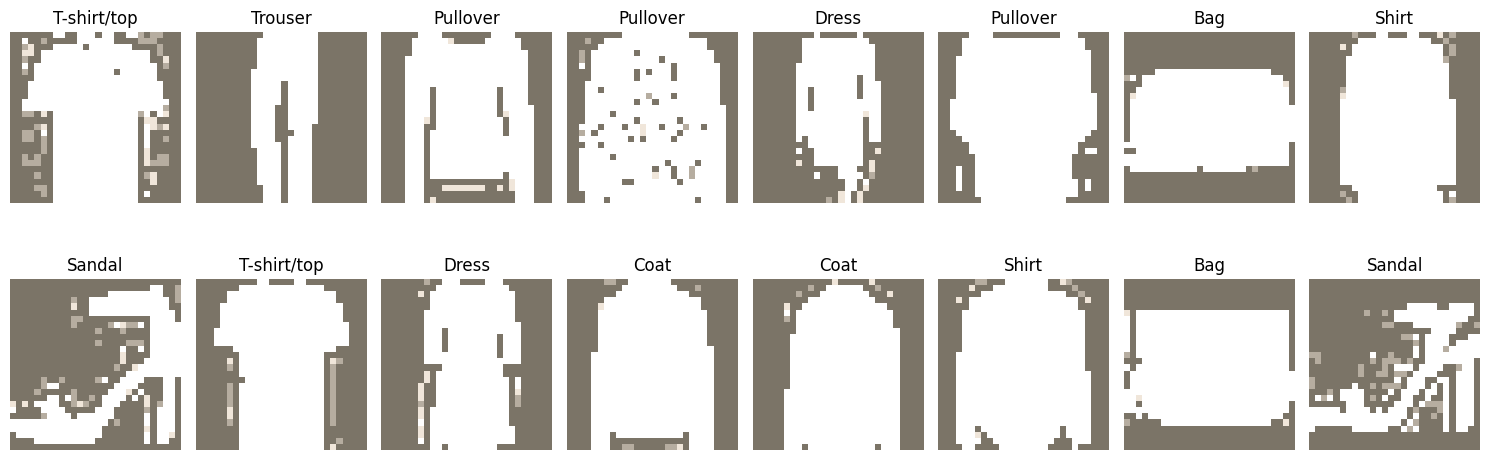

In [ ]:
images, labels = next(iter(testloader))
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1., top=1., wspace=0.05, hspace=0.05)

for i in range(BATCH_SIZE):
  ax = fig.add_subplot(BATCH_SIZE//8, 8, (i+1) , xticks=[], yticks=[])
  fn_imshow(images[i], ax= ax, normalize=True,
            title=class_names[labels[i].item()])
plt.tight_layout()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Before defining the linear layers, calculate the flattened features dynamically
numchannels = 3


#  in and out channels in the models
out_channels1 = 32
out_channels2 = 64
out_channels3 = 128
out_channels4 = 256
out_channels5 = 256

# dropout rates
dor1 = 0.15
dor2 = 0.15
dor3 = 0.15
dor4 = 0.15
dor5 = 0.15

# Create a sequential model that includes all layers up to Flatten
conv_layers = nn.Sequential(
    # --SET1---
    nn.Conv2d(numchannels, out_channels1, padding='same', kernel_size=(3,3)),
    nn.BatchNorm2d(out_channels1),
    nn.ReLU(),
    nn.Dropout(p=dor1),
    nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),

    # --SET2---
    nn.Conv2d(out_channels1, out_channels2, padding='same', kernel_size=(3,3)),
    nn.BatchNorm2d(out_channels2),
    nn.ReLU(),
    nn.Dropout(p=dor2),
    nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),

    # ---set3 ---
    nn.Conv2d(out_channels2, out_channels3, padding='same', kernel_size=(3,3)),
    nn.BatchNorm2d(out_channels3),
    nn.ReLU(),
    nn.Dropout(p=dor3),
    nn.MaxPool2d(kernel_size=(2,2), stride = (2,2)),

    # -----set4---
    nn.Conv2d(out_channels3, out_channels4, kernel_size=(3,3)), # No 'same' padding here
    nn.BatchNorm2d(out_channels4),
    nn.ReLU(),
    nn.Dropout(p=dor4),
)

# Pass a dummy tensor through the conv_layers to get the output shape
dummy_input = torch.randn(2, numchannels, 28, 28) # Changed batch size from 1 to 2
output_of_conv_layers = conv_layers(dummy_input)
# The shape will now be [2, 256, 1, 1], but we only need the spatial and channel dimensions
flattened_features = output_of_conv_layers.shape[1] * output_of_conv_layers.shape[2] * output_of_conv_layers.shape[3]

# Now define the complete model using the calculated flattened_features
model = nn.Sequential(
    conv_layers, # Include the defined conv_layers sequential
    nn.Flatten(), # Flatten the output of conv_layers

    # ---set5---
    nn.Linear(in_features=flattened_features, # Use the calculated flattened_features
              out_features=out_channels5),
    nn.BatchNorm1d(out_channels5),
    nn.ReLU(),
    nn.Dropout(p=dor5),

    nn.Linear(in_features=out_channels5,
              out_features=10),
    nn.Softmax(dim=1).to(device=device)  # output layer
)

print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.15, inplace=False)
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [ ]:
def fn_split_features_labels(row):
  feature = tf.reshape(row[1:], [IMG_HEIGHT, IMG_WIDTH, numchannels])
  label = row[0]
  return feature, label


In [ ]:
# initialize our optimizer and loss function
opt = torch.optim.Adam(model.parameters(), lr=ALPHA, weight_decay=0.001)

# loss function
loss_fn = nn.CrossEntropyLoss()

# initializing learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                        mode='min',
                                                        factor=LR_FACTOR,
                                                        patience=LR_PATIENCE,
                                                        min_lr=1e-6)

In [ ]:
# measure how long training is going to take
print("[INFO] Training the network...")
startTime = time.time()

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# Move model to device
model = model.to(device)

# initialize a dictionary to store training history
H = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
    'alpha': []
}

# loop over our epochs
for e in range(0, EPOCHS):
    epochStart = time.time()

    # set the model in training mode
    model.train()

    # initialize the average training and validation loss
    avgTrainLoss = 0
    avgTestLoss = 0

    # initialize the number of correct predictions
    trainAcc = 0
    testAcc = 0

    # loop over the training set
    for count, (images, labels) in enumerate(trainloader):
        # Move data to device
        images = images.float().to(device)  # Convert to float32 and move to device
        labels = labels.to(device)

        # If your images are in range 0-255, you might want to normalize:
        # images = images.float() / 255.0

        # perform a forward pass and calculate the training loss
        pred_train = model(images)
        train_loss = loss_fn(pred_train, labels)
        y_pred = pred_train.argmax(1)

        # zero out the gradients, perform backpropagation, and update weights
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        # update running averages
        avgTrainLoss += (train_loss.item() - avgTrainLoss) / (count + 1)
        curr_acc = accuracy_score(labels.cpu().numpy(), y_pred.cpu().numpy())
        trainAcc += (curr_acc - trainAcc) / (count + 1)

    # Validation phase
    with torch.no_grad():
        model.eval()

        for count, (images, labels) in enumerate(testloader):
            # Move data to device
            images = images.float().to(device)
            labels = labels.to(device)

            pred_test = model(images)
            y_pred = pred_test.argmax(1)
            test_loss = loss_fn(pred_test, labels)

            avgTestLoss += (test_loss.item() - avgTestLoss) / (count + 1)
            curr_acc = accuracy_score(labels.cpu().numpy(), y_pred.cpu().numpy())
            testAcc += (curr_acc - testAcc) / (count + 1)

        # Update learning rate
        lr_scheduler.step(avgTestLoss)

    # Update training history
    H["epoch"].append(e)
    H["train_loss"].append(avgTrainLoss)
    H["test_loss"].append(avgTestLoss)
    H["train_acc"].append(trainAcc)
    H["test_acc"].append(testAcc)
    H["alpha"].append(lr_scheduler.get_last_lr()[0])

    # if e % 10 == 0:
    print(f'[INFO] EPOCH: {e:3d}/{EPOCHS} Loss: {avgTrainLoss:.6f} / {avgTestLoss:.6f}',
          f'| Accuracy: {trainAcc:.4f} / {testAcc:.4f}',
          f'| alpha: {lr_scheduler.get_last_lr()[0]:.7f}',
          f'in : {time.time() - epochStart:.2f} sec.')

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f} min".format((endTime - startTime) / 60.))

[INFO] Training the network...
[INFO] Using device: cuda
[INFO] EPOCH:   0/50 Loss: 1.659725 / 1.609192 | Accuracy: 0.8152 / 0.8640 | alpha: 0.0010000 in : 30.46 sec.
[INFO] EPOCH:   1/50 Loss: 1.624517 / 1.598155 | Accuracy: 0.8479 / 0.8783 | alpha: 0.0010000 in : 30.66 sec.
[INFO] EPOCH:   2/50 Loss: 1.616278 / 1.633836 | Accuracy: 0.8551 / 0.8379 | alpha: 0.0010000 in : 29.11 sec.
[INFO] EPOCH:   3/50 Loss: 1.610832 / 1.606080 | Accuracy: 0.8607 / 0.8736 | alpha: 0.0010000 in : 30.92 sec.
[INFO] EPOCH:   4/50 Loss: 1.606633 / 1.582014 | Accuracy: 0.8657 / 0.8912 | alpha: 0.0010000 in : 30.45 sec.
[INFO] EPOCH:   5/50 Loss: 1.605843 / 1.604161 | Accuracy: 0.8658 / 0.8665 | alpha: 0.0010000 in : 29.91 sec.
[INFO] EPOCH:   6/50 Loss: 1.604543 / 1.586732 | Accuracy: 0.8669 / 0.8887 | alpha: 0.0010000 in : 29.76 sec.
[INFO] EPOCH:   7/50 Loss: 1.605370 / 1.588568 | Accuracy: 0.8666 / 0.8858 | alpha: 0.0010000 in : 29.33 sec.
[INFO] EPOCH:   8/50 Loss: 1.601734 / 1.596030 | Accuracy: 0.87

In [ ]:
loss_df = pd.DataFrame(H)
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,train_loss,test_loss,train_acc,test_acc,alpha
42,42,1.559664,1.546043,0.910917,0.9223,0.0001


In [ ]:
def fn_plot_tf_hist(hist_df):
        fig, axes = plt.subplots(1, 2, figsize = (15, 5))

        # y1 = hist_df.columns["train_acc"]
        # y2 = hist_df.columns["train_loss"]
        # y3 = hist_df.columns["test_acc"]
        # y4 = hist_df.columns["test_loss"]

        y1 = "train_acc"
        y2 = "train_loss"
        y3 = "test_acc"
        y4 = "test_loss"

        best = hist_df[hist_df[y4] == hist_df[y4].min()]
        props = dict (boxstyle = 'round', facecolor = 'cyan', alpha = 0.4)
        facecolor = 'cyan'
        fontsize = 12
        CMAP = plt.cm.coolwarm

        ax = axes[0]
        hist_df.plot(y=[y2, y4], ax=ax, colormap= CMAP)
        txtFmt = 'Loss:\n   train: {:6.4f}\n    test: {:6.4f}'
        txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                        hist_df.iloc[-1][y4])

        ax.text(0.3, 0.95, txtstr,
                transform=ax.transAxes,
                fontsize = fontsize,
                verticalalignment = 'top',
                bbox = props)

        # Arrow offset markings
        y_min = min(hist_df[y2].min(), hist_df[y4].min())
        y_max = max(hist_df[y2].max(), hist_df[y4].max())
        offset = (y_max - y_min)/10.0

        ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4}', # text to print
                xy = (best.index.to_numpy(), best[y4].to_numpy()[0]), #start
                xytext = (best.index.to_numpy(), best[y4].to_numpy()[0]+offset),
                fontsize=fontsize, va = 'bottom', ha='right', bbox=props,
                arrowprops = dict(facecolor = facecolor, shrink=0.05)
                )
        ax.axvline(best.index.to_numpy(), color='g',
                linestyle = '-.', lw = 3,
                )
        ax.set_xlabel('Epochs')
        ax.set_ylabel(y2.capitalize())

        ax = axes[1]
        hist_df.plot(y=[y1, y3], ax=ax, colormap= CMAP)
        txtFmt = 'Loss:\n   train: {:6.4f}\n    test: {:6.4f}'
        txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                        hist_df.iloc[-1][y3])

        ax.text(0.3, 0.2, txtstr,
                transform=ax.transAxes,
                fontsize = fontsize,
                verticalalignment = 'top',
                bbox = props)

        # Arrow offset markings
        y_min = min(hist_df[y1].min(), hist_df[y3].min())
        y_max = max(hist_df[y1].max(), hist_df[y3].max())
        offset = (y_max - y_min)/10.0

        ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4}', # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]), #start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0]+offset),
                fontsize=fontsize, va = 'bottom', ha='right', bbox=props,
                arrowprops = dict(facecolor = facecolor, shrink=0.05)
                )

        ax.axvline(best.index.to_numpy(), color='g',
                linestyle = '-.', lw = 3,
                )

        ax.set_xlabel('Epochs')
        ax.set_ylabel(y2.capitalize())
        ax.grid()
        plt.suptitle('Training Performance')
        plt.tight_layout()

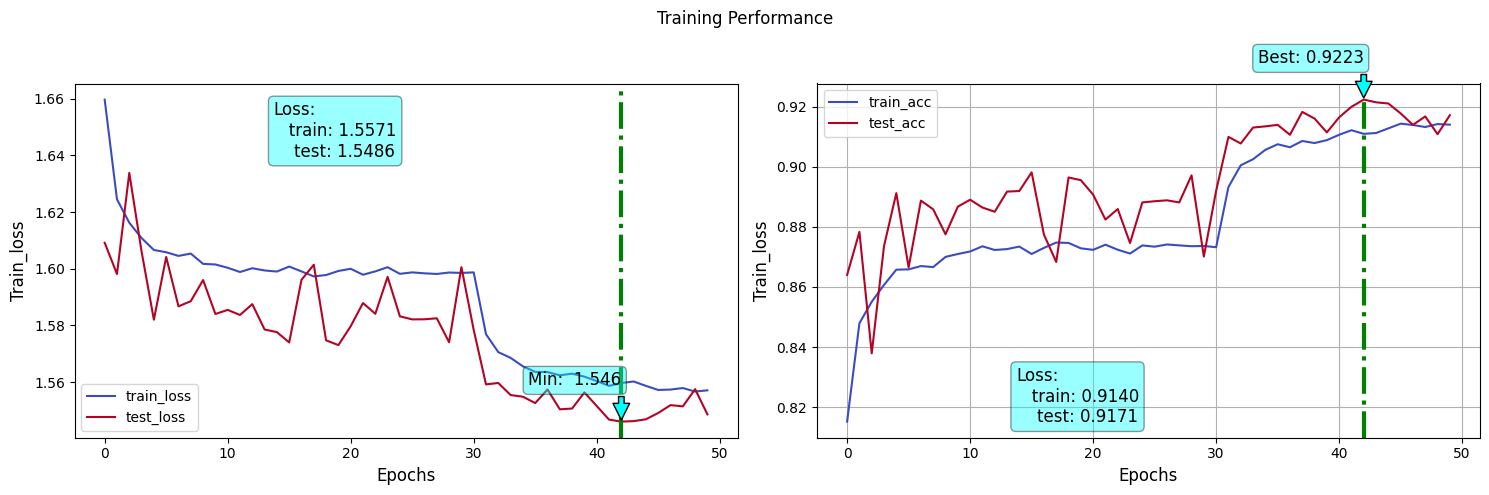

In [ ]:
fn_plot_tf_hist(loss_df)

In [ ]:
with torch.no_grad():

    # set the model in evaluation mode
    model.eval()

    # initialize a list to store our predictions
    y_pred = []
    y_true = []
    # loop over the test set
    for (images, labels) in trainloader:

        # send the input to the device
        images = images.float().to(device)
        y_true.extend(labels.cpu().numpy())
        # make the predictions and add them to the list
        output = model(images)
        preds = output.argmax(axis=1).cpu().numpy()
        y_pred.extend(preds)

print (f'Accuracy:{accuracy_score(y_true , y_pred) : 0.4f}\n')

print(classification_report ( y_true, y_pred,
                             target_names = class_names.values() ) )

Accuracy: 0.9310

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.88      0.90      6000
     Trouser       0.99      0.99      0.99      6000
    Pullover       0.90      0.90      0.90      6000
       Dress       0.91      0.95      0.93      6000
        Coat       0.90      0.86      0.88      6000
      Sandal       0.99      0.97      0.98      6000
       Shirt       0.79      0.82      0.81      6000
     Sneaker       0.95      0.99      0.97      6000
         Bag       0.99      0.98      0.99      6000
  Ankle Boot       0.98      0.97      0.97      6000

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000



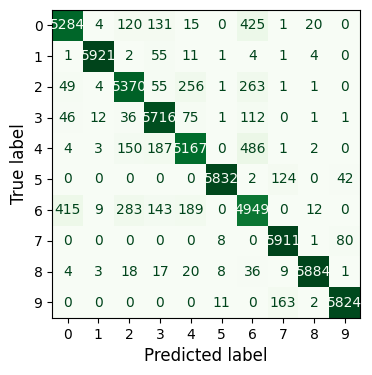

In [ ]:
train_cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
fig, ax = plt.subplots(figsize = (4,4))
disp.plot(ax =ax, cmap = 'Greens', colorbar=False);

In [ ]:
with torch.no_grad():

    # set the model in evaluation mode
    model.eval()

    # initialize a list to store our predictions
    y_pred = []
    y_true = []
    incorect = {'images': [], 'y_true' : [], 'y_pred' : []}
    # loop over the test set
    for (images, labels) in testloader:

        # send the input to the device
        images = images.float().to(device)
        # make the predictions and add them to the list
        output = model(images)
        preds = output.argmax(axis=1).cpu().numpy()
        y_pred.extend(preds)
        labels = labels.cpu().numpy()
        y_true.extend(labels)

        # collect incorrect samples
        incorect['images'].extend(images[labels != preds].cpu())
        incorect['y_true'].extend(labels[labels != preds])
        incorect['y_pred'].extend(preds[labels != preds])

print (f'Accuracy:{accuracy_score(y_true , y_pred) : 0.4f}\n')

print(classification_report ( y_true, y_pred,
                             target_names = class_names.values() ) )

Accuracy: 0.9171

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.85      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.87      0.88      1000
       Dress       0.90      0.95      0.92      1000
        Coat       0.89      0.85      0.87      1000
      Sandal       1.00      0.96      0.98      1000
       Shirt       0.74      0.78      0.76      1000
     Sneaker       0.93      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle Boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



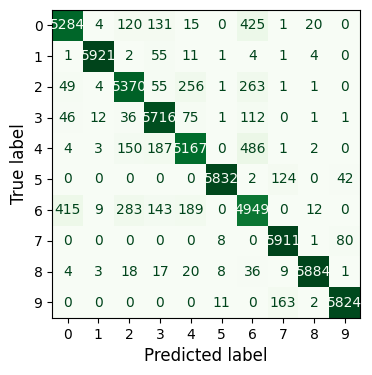

In [ ]:
test_cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
fig, ax = plt.subplots(figsize = (4,4))
disp.plot(ax =ax, cmap = 'Greens', colorbar=False);